# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [8]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [21]:
 # Correct path to your Excel file
file_path = 'WineKMC.xlsx'

# Read the Excel file into a DataFrame
try:
    df_offers = pd.read_excel(file_path, engine='openpyxl')
    print(df.head())
except FileNotFoundError:
    print(f"The file {file_path} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

   Offer #  Campaign            Varietal  Minimum Qty (kg)  Discount (%)  \
0        1   January              Malbec                72            56   
1        2   January          Pinot Noir                72            17   
2        3  February           Espumante               144            32   
3        4  February           Champagne                72            48   
4        5  February  Cabernet Sauvignon               144            44   

        Origin  Past Peak  
0       France      False  
1       France      False  
2       Oregon       True  
3       France       True  
4  New Zealand       True  


/Users/admin/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [22]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [23]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/admin/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [26]:
# Merge transactions with offers 
data = df_transactions.merge(df_offers, on='offer_id', how='left')

# Create a pivot table
pivot_table = data.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0, aggfunc='max')

# Reset the index to have customer_name as a column
pivot_table.reset_index(inplace=True)

# Display the resulting pivot table
print(pivot_table.head())


offer_id customer_name  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  \
0                Adams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   
2             Anderson  0  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   
3               Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   

offer_id  28  29  30  31  32  
0          0   1   1   0   0  
1          0   0   0   0   0  
2          0   0   0   0   0  
3          0   0   1   0   0  
4          0   0   0   1   0  

[5 rows x 33 columns]


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

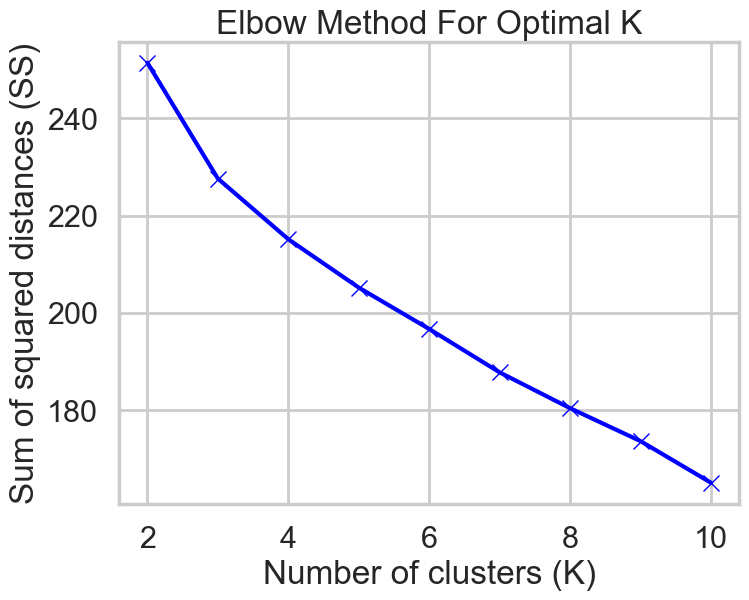

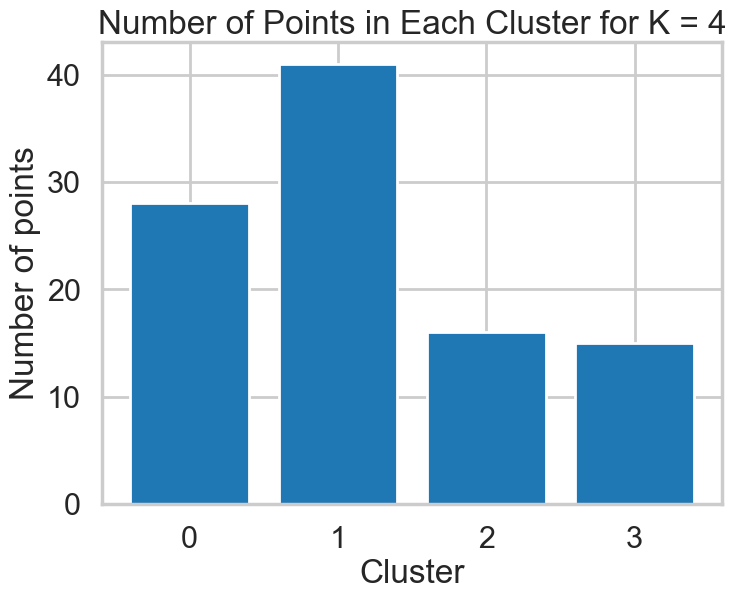

In [29]:
# Create a numpy matrix x_cols with only the columns representing the offers (excluding 'customer_name')
x_cols = pivot_table.drop(columns=['customer_name']).to_numpy()

# List to store the sum of squared distances
sum_of_squared_distances = []

# Test values for K from 2 to 10
K_range = range(2, 11)

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(x_cols)
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot SS for each K
plt.figure(figsize=(8, 6))
plt.plot(K_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SS)')
plt.title('Elbow Method For Optimal K')
plt.show()

# Assume the best K is determined to be 4 (for example)
best_K = 4
kmeans = KMeans(n_clusters=best_K, random_state=0, n_init=10).fit(x_cols)
clusters = kmeans.labels_

# Count the number of points in each cluster
cluster_counts = np.bincount(clusters)

# Make a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(best_K), cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of points')
plt.title(f'Number of Points in Each Cluster for K = {best_K}')
plt.show()

In [ ]:
#What challenges did you experience using the Elbow method to pick  𝐾?  
Answer: There is not much of an elbow as the line descends pretty evenly and lines have approximately the same slope.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# I drop the 'customer_name' column for clustering:
X = pivot_table.drop('customer_name', axis=1)

print(X.head())

offer_id  1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  27  28  \
0          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1          0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   1   0   
2          0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   0   0   
3          0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   
4          0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   0   0   

offer_id  29  30  31  32  
0          1   1   0   0  
1          0   0   0   0  
2          0   0   0   0  
3          0   1   0   0  
4          0   0   1   0  

[5 rows x 32 columns]


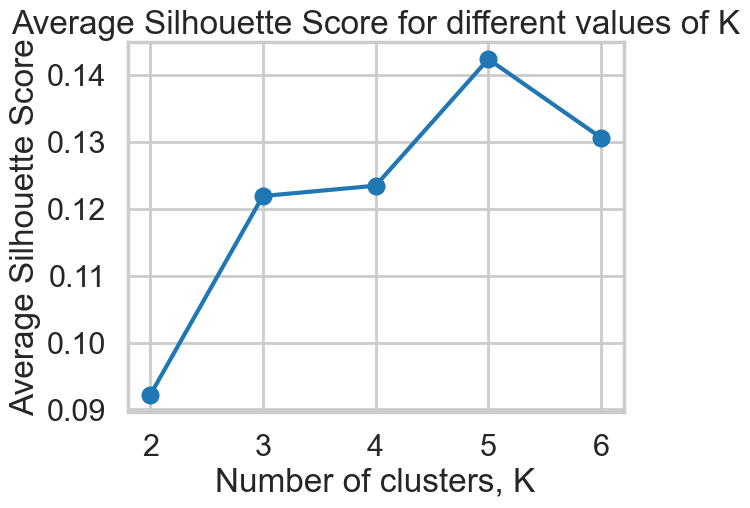

In [39]:
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

plt.figure()
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score for different values of K')
plt.show()

In [ ]:
#Analysis: The highest score is 0.14 with 5 clusters. It's difficult to say if this is 
#different from the KMeans "elbow" method but would certainly be consistent with it.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [40]:
from sklearn.decomposition import PCA
# I drop the 'customer_name' column for clustering:
X = pivot_table.drop('customer_name', axis=1)

print(X.head())
# Apply PCA to reduce the data to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=X_pca, columns=['x', 'y'])

# Add the customer name and cluster ID to the DataFrame
pca_df['customer_name'] = pivot_table['customer_name']
pca_df['cluster_id'] = cluster_labels

print(pca_df.head())

offer_id  1   2   3   4   5   6   7   8   9   10  ...  23  24  25  26  27  28  \
0          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1          0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   1   0   
2          0   0   0   0   0   0   0   0   0   0  ...   0   1   0   1   0   0   
3          0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   
4          0   0   0   0   0   0   1   0   0   1  ...   0   0   0   0   0   0   

offer_id  29  30  31  32  
0          1   1   0   0  
1          0   0   0   0  
2          0   0   0   0  
3          0   1   0   0  
4          0   0   1   0  

[5 rows x 32 columns]
          x         y customer_name  cluster_id
0  1.007580  0.108215         Adams           0
1 -0.287539  0.044715         Allen           4
2 -0.392032  1.038391      Anderson           2
3  0.699477 -0.022542        Bailey           0
4  0.088183 -0.471695         Baker           3


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

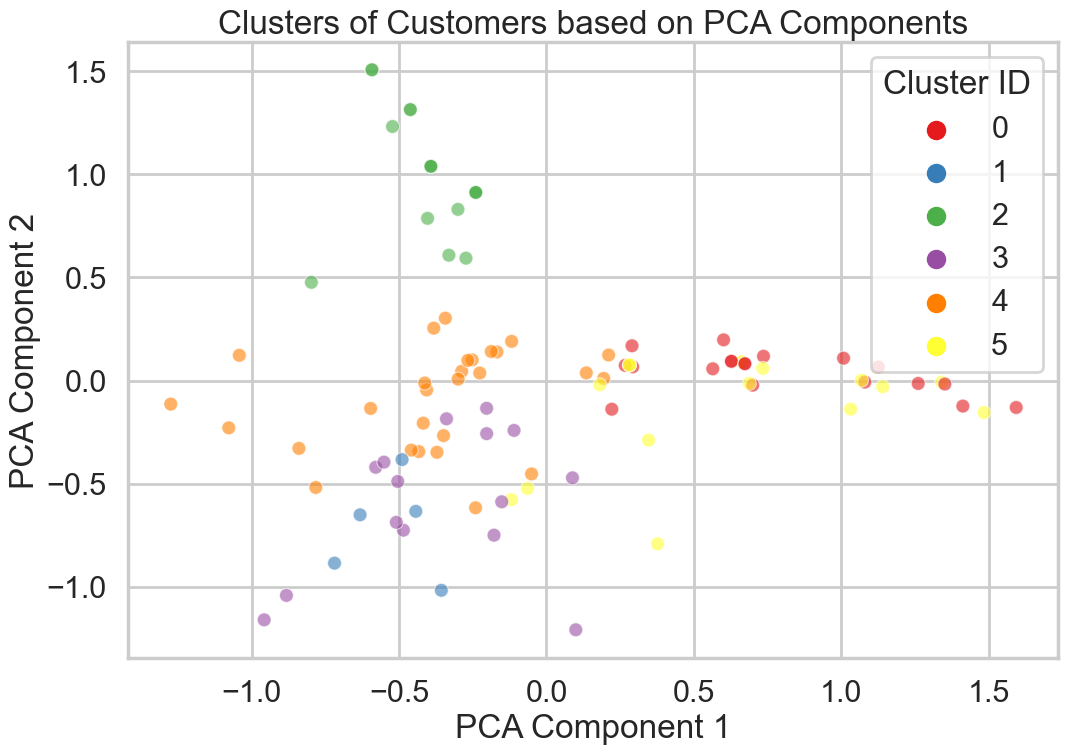

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='cluster_id', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('Clusters of Customers based on PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

In [42]:
cluster_analysis = data.merge(pca_df[['customer_name', 'cluster_id']], on='customer_name')

#Group by cluster and summarize the data
cluster_summary = cluster_analysis.groupby('cluster_id').agg({
    'offer_id': 'count',  # Number of offers
    'n': 'sum'  # Total interactions
}).reset_index()

print(cluster_summary)

   cluster_id  offer_id   n
0           0        51  51
1           1        22  22
2           2        43  43
3           3        63  63
4           4        94  94
5           5        51  51


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

[0.14386393 0.10800289 0.07104281 0.05866151 0.05273181 0.05037351
 0.04853032 0.04281792 0.04086488 0.03794334 0.03490044 0.03334871
 0.03051951 0.02548482 0.02321341 0.02193338 0.01978732 0.01870919
 0.016607   0.0154309  0.01369783 0.01273333 0.01213607 0.01136126
 0.01032716 0.00919489 0.00810601 0.00752468 0.00660726 0.00580346
 0.0050086  0.00273186]


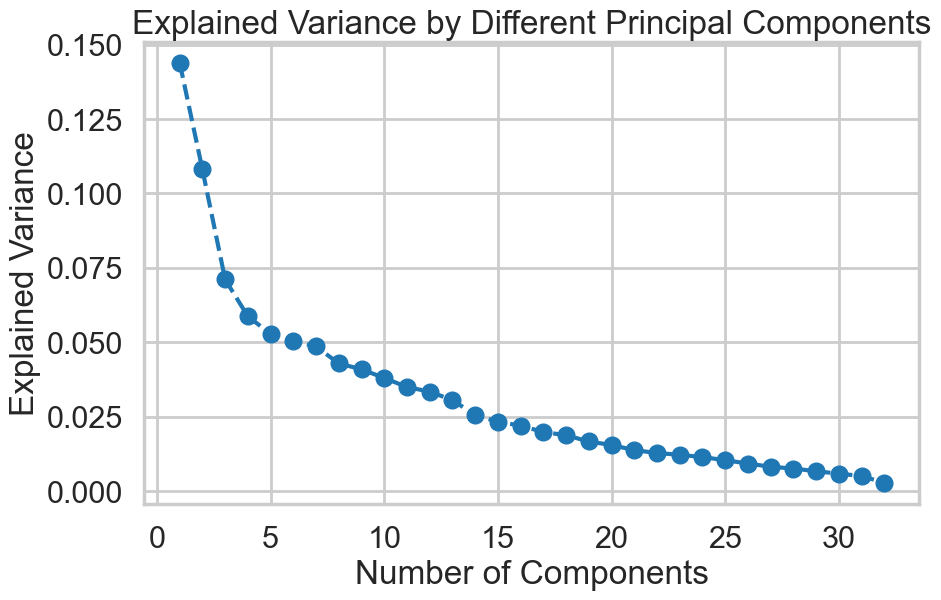

In [43]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
import matplotlib.pyplot as plt

# Initialize PCA
pca = sklearn.decomposition.PCA()

# Fit PCA on the data
pca.fit(X)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

# Print the explained variance for each component
print(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.show()


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

In [ ]:
Conclusions from PCA Explained Variance Plot:
The "elbow point" is where the curve's rate of descent sharply slows down. 
In the plot the elbow point appears to be around the 3rd principal component. 
This indicates that the first three components capture most of the variance in the data, 
and adding more components results in diminishing returns.

The first three components capture approximately 32.4% of the total variance 
(0.14386393 + 0.10800289 + 0.07104281 ≈ 0.3229). This is a significant portion, suggesting 
that these components are essential for representing the underlying structure of the data.
Dimensionality Reduction:

Given the sharp drop in explained variance after the 3rd component, reducing the data to 
three principal components seems reasonable. This reduction will simplify the data while 
retaining most of the critical information.

My Next Steps will be using three principal components. This will balance simplicity and 
information retention. I will validate with clustering, applying KMeans and other tools
to the data reduced to three principal components and visualize the clusters. 
I will also check if the clusters make sense and are well-separated. ntify if there are 
patterns or insights, such as certain customer behaviors or preferences for specific offers.


Discussion Points for Mentor Call

-Elbow Point Determination:
talk about the elbow point and its significance in selecting the optimal number of 
dimensions. It would also be good to discuss how the first three principal components 
capture a significant portion of the variance and why it justifies dimensionality 
reduction to three components.

-Clustering Validation: we should determine how the clustering aligns with business insights or customer segmentation.



### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [45]:
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce the data to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=X_pca, columns=['x', 'y', 'z'])

# Add the customer name to the DataFrame
pca_df['customer_name'] = pivot_table['customer_name']

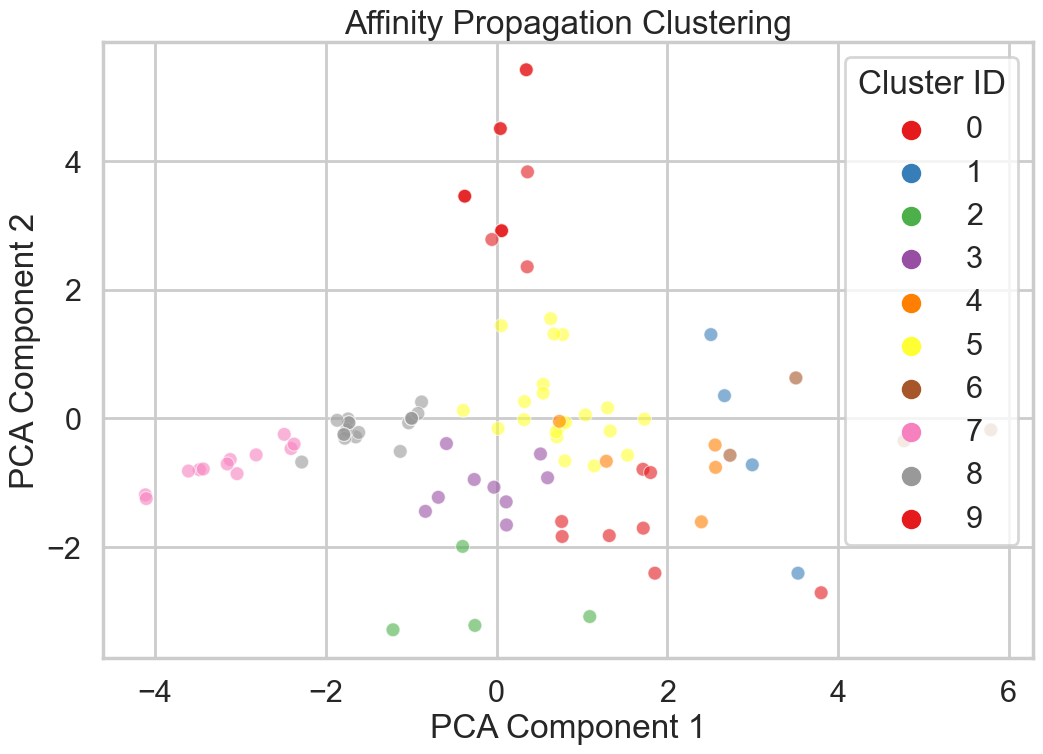

In [46]:
# Affinity Propagation
affinity_propagation = AffinityPropagation(random_state=42)
pca_df['affinity_propagation'] = affinity_propagation.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='affinity_propagation', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('Affinity Propagation Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

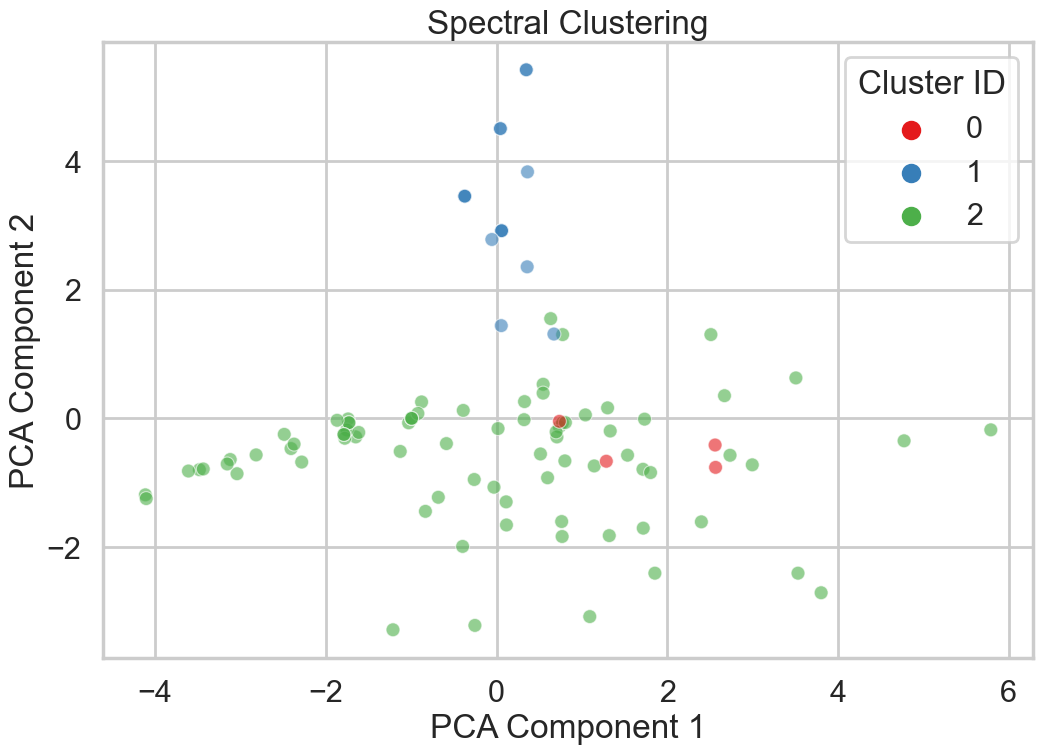

In [47]:
# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=42)
pca_df['spectral_clustering'] = spectral_clustering.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='spectral_clustering', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('Spectral Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

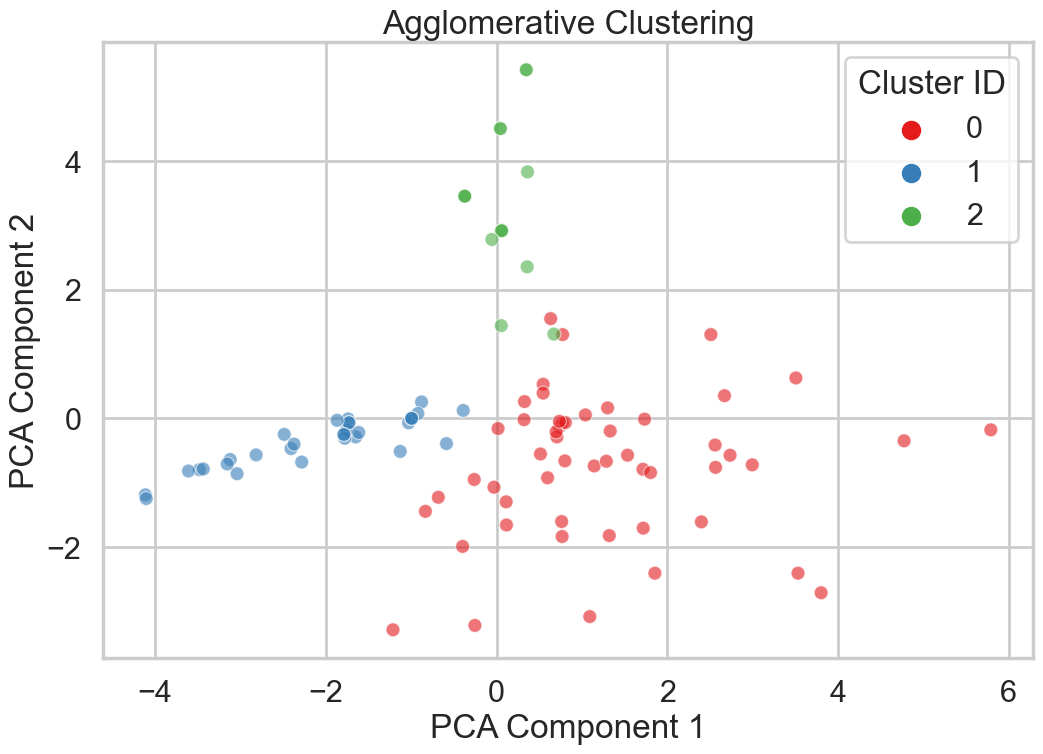

In [48]:
# Agglomerative Clustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=3)
pca_df['agglomerative_clustering'] = agglomerative_clustering.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='agglomerative_clustering', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

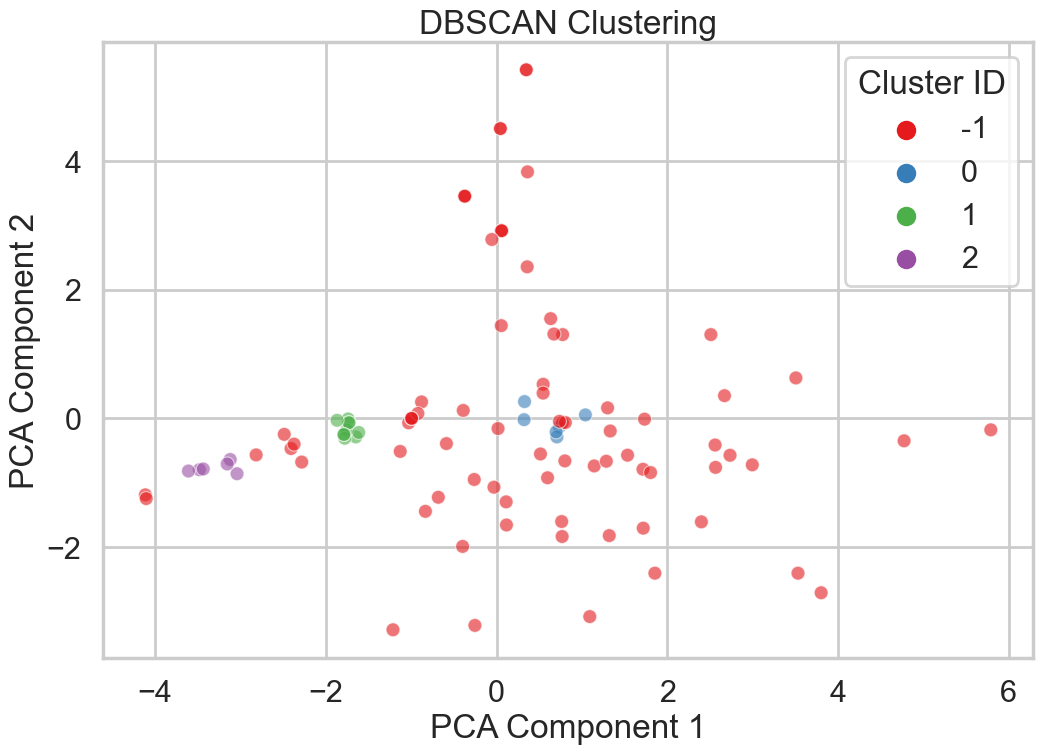

In [49]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
pca_df['dbscan'] = dbscan.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='dbscan', data=pca_df, palette='Set1', s=100, alpha=0.6)
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

In [ ]:
Affinity Propagation Clustering identified 10 distinct clusters, which seem to be somewhat 
spread out and overlapping. While it captures a diverse range of clusters, many clusters 
may lead to over-segmentation, and some clusters have significant overlap.

Spectral Clustering identified 3 clusters with distinct separation, especially between 
cluster 1 (blue) and clusters 0 (red) and 2 (green). There is definite separation between 
clusters, indicating a good balance between clustering and separation.
However, fewer clusters might miss finer distinctions in the data.

Agglomerative Clustering also identified 3 clusters. But there is some mixing of points 
between clusters, particularly clusters 0 (red) and 2 (green).Here there is simplicity and 
interpretability with fewer clusters, but mixed clusters might indicate weaker separation 
compared to Spectral Clustering.

DBSCAN also identified 3 clusters and marked some points as noise (cluster -1). While DBSCAN
identifies noise and outliers pretty well, which can be useful for noisy data, but some 
clusters are large and may contain diverse points, indicating potential under-segmentation.

In conclusion, Spectral Clustering seems to perform the best because it provides distinct 
separation between clusters with minimal overlap, which indicates that it is capturing the 
underlying structure of the data well. In identifying a moderate number of clusters (3), Spectral
Clustering balances between over-segmentation (as seen in Affinity Propagation) and 
under-segmentation (potentially seen in DBSCAN). The clusters are also easy to interpret 
and visualize, which is essential for understanding customer behavior.

Spectral Clustering likely performs the best because it captures the global structure of the
data effectively. By transforming the data into a lower-dimensional space and then 
performing clustering, it can identify well-separated clusters that correspond to
meaningful groupings in the data. This method is particularly advantageous when the data 
has a clear, albeit complex, structure that other methods might either over-complicate 
(Affinity Propagation) or oversimplify (DBSCAN and Agglomerative Clustering).

